This is a test example of using solvent accessible surface area as metric to cluster protein snapshots

First we use simple sasa as boolean for all atoms to calculate

In [ ]:
import hdbscan
import mdtraj
import alphaspace
import numpy as np
from numba import *
from itertools import combinations
import hdbscan
import matplotlib.pyplot as plt
import hypertools as hyp
import _pickle as pickle

%matplotlib notebook

# trajectory = mdtraj.load('/Users/haotian/Trajectory/md1/bcl2.holo1.2000.h5')

trajectory = mdtraj.load('/Users/haotian/Trajectory/holo/md2/bcl2.holo1.{}.h5'.format(10))


for i in range(20,210,10):
    trajectory = trajectory.join(mdtraj.load('/Users/haotian/Trajectory/holo/md2/bcl2.holo1.{}.h5'.format(i)))
    print(i)
    
# trajectory.save_hdf5('/Users/haotian/Trajectory/md1/bcl2.holo1.2000.h5')


# with open('/Users/haotian/Trajectory/md1/sasa_delta.pickle','rb') as handle:
#     abs_sasa_list = pickle.load(handle)
# with open('/Users/haotian/Trajectory/md1/sasa_abs.pickle','rb') as handle:
#     sasa_list = pickle.load(handle)

20
30
40
50
60
70
80


## RMSD calculation
    

In [43]:
molecules = trajectory.top.find_molecules()
rmsd_matrix = []
for i in range(2000):
    rmsd = mdtraj.rmsd(trajectory,trajectory,i,atom_indices=[atom.index for atom in molecules[0]])
    rmsd_matrix.append(rmsd)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [7]:
u = alphaspace.AS_Universe(trajectory,guess_by_order=False)


u.run_alphaspace_mp()

# sasa_list = []
# abs_sasa_list = []
# for si in u.snapshots_indices:
#     print("calculating sasa for snapshot {}".format(si))
#     # Calculate the sasa
#     sasa = alphaspace.getSASA(u.receptor.traj[si])
#     sasa_list.append(sasa)
    
#     # Absolute SASA
#     beta_coords = []
#     for pocket in u.pockets(si):
#         for beta in pocket.betas:
#             beta_coords.append(beta.centroid)
            
#     covered_sasa = alphaspace.getSASA(u.receptor.traj[si],np.array(beta_coords))
#     abs_sasa_list.append(sasa - covered_sasa)

3 snapshot processed
4 snapshot processed
2 snapshot processed
1 snapshot processed
5 snapshot processed
6 snapshot processed
8 snapshot processed
7 snapshot processed
9 snapshot processed
10 snapshot processed
12 snapshot processed
11 snapshot processed
13 snapshot processed
15 snapshot processed
14 snapshot processed
16 snapshot processed
17 snapshot processed
19 snapshot processed
18 snapshot processed
20 snapshot processed
21 snapshot processed
22 snapshot processed
23 snapshot processed
24 snapshot processed
25 snapshot processed
26 snapshot processed
28 snapshot processed
27 snapshot processed
30 snapshot processed
31 snapshot processed
32 snapshot processed
29 snapshot processed
33 snapshot processed
34 snapshot processed
35 snapshot processed
36 snapshot processed
37 snapshot processed
38 snapshot processed
40 snapshot processed
39 snapshot processed
42 snapshot processed
41 snapshot processed
44 snapshot processed
43 snapshot processed
45 snapshot processed
46 snapshot process

362 snapshot processed
363 snapshot processed
364 snapshot processed
365 snapshot processed
366 snapshot processed
367 snapshot processed
368 snapshot processed
369 snapshot processed
371 snapshot processed
370 snapshot processed
372 snapshot processed
373 snapshot processed
374 snapshot processed
375 snapshot processed
377 snapshot processed
376 snapshot processed
378 snapshot processed
379 snapshot processed
380 snapshot processed
381 snapshot processed
382 snapshot processed
383 snapshot processed
384 snapshot processed
385 snapshot processed
386 snapshot processed
387 snapshot processed
388 snapshot processed
389 snapshot processed
390 snapshot processed
391 snapshot processed
392 snapshot processed
393 snapshot processed
394 snapshot processed
395 snapshot processed
396 snapshot processed
397 snapshot processed
398 snapshot processed
399 snapshot processed
400 snapshot processed
401 snapshot processed
402 snapshot processed
403 snapshot processed
404 snapshot processed
405 snapsho

718 snapshot processed
720 snapshot processed
721 snapshot processed
723 snapshot processed
722 snapshot processed
725 snapshot processed
724 snapshot processed
726 snapshot processed
727 snapshot processed
728 snapshot processed
729 snapshot processed
730 snapshot processed
731 snapshot processed
732 snapshot processed
733 snapshot processed
734 snapshot processed
735 snapshot processed
736 snapshot processed
737 snapshot processed
739 snapshot processed
740 snapshot processed
741 snapshot processed
738 snapshot processed
745 snapshot processed
742 snapshot processed
743 snapshot processed
744 snapshot processed
746 snapshot processed
747 snapshot processed
748 snapshot processed
749 snapshot processed
750 snapshot processed
752 snapshot processed
751 snapshot processed
753 snapshot processed
754 snapshot processed
755 snapshot processed
756 snapshot processed
757 snapshot processed
758 snapshot processed
760 snapshot processed
759 snapshot processed
761 snapshot processed
762 snapsho

1073 snapshot processed
1074 snapshot processed
1075 snapshot processed
1076 snapshot processed
1077 snapshot processed
1078 snapshot processed
1079 snapshot processed
1081 snapshot processed
1080 snapshot processed
1082 snapshot processed
1083 snapshot processed
1085 snapshot processed
1084 snapshot processed
1086 snapshot processed
1087 snapshot processed
1089 snapshot processed
1088 snapshot processed
1090 snapshot processed
1091 snapshot processed
1092 snapshot processed
1093 snapshot processed
1094 snapshot processed
1095 snapshot processed
1097 snapshot processed
1098 snapshot processed
1096 snapshot processed
1099 snapshot processed
1100 snapshot processed
1101 snapshot processed
1103 snapshot processed
1102 snapshot processed
1104 snapshot processed
1105 snapshot processed
1106 snapshot processed
1107 snapshot processed
1108 snapshot processed
1109 snapshot processed
1110 snapshot processed
1111 snapshot processed
1112 snapshot processed
1113 snapshot processed
1114 snapshot pr

1415 snapshot processed
1416 snapshot processed
1417 snapshot processed
1419 snapshot processed
1418 snapshot processed
1420 snapshot processed
1421 snapshot processed
1424 snapshot processed
1422 snapshot processed
1423 snapshot processed
1425 snapshot processed
1427 snapshot processed
1428 snapshot processed
1426 snapshot processed
1429 snapshot processed
1431 snapshot processed
1432 snapshot processed
1430 snapshot processed
1433 snapshot processed
1434 snapshot processed
1436 snapshot processed
1435 snapshot processed
1437 snapshot processed
1438 snapshot processed
1440 snapshot processed
1439 snapshot processed
1441 snapshot processed
1442 snapshot processed
1443 snapshot processed
1444 snapshot processed
1445 snapshot processed
1446 snapshot processed
1447 snapshot processed
1448 snapshot processed
1449 snapshot processed
1450 snapshot processed
1451 snapshot processed
1452 snapshot processed
1453 snapshot processed
1454 snapshot processed
1455 snapshot processed
1456 snapshot pr

1757 snapshot processed
1758 snapshot processed
1759 snapshot processed
1761 snapshot processed
1760 snapshot processed
1762 snapshot processed
1763 snapshot processed
1764 snapshot processed
1765 snapshot processed
1766 snapshot processed
1768 snapshot processed
1767 snapshot processed
1769 snapshot processed
1770 snapshot processed
1771 snapshot processed
1772 snapshot processed
1773 snapshot processed
1774 snapshot processed
1775 snapshot processed
1776 snapshot processed
1777 snapshot processed
1778 snapshot processed
1779 snapshot processed
1780 snapshot processed
1781 snapshot processed
1782 snapshot processed
1783 snapshot processed
1784 snapshot processed
1785 snapshot processed
1787 snapshot processed
1786 snapshot processed
1788 snapshot processed
1789 snapshot processed
1790 snapshot processed
1791 snapshot processed
1792 snapshot processed
1793 snapshot processed
1794 snapshot processed
1795 snapshot processed
1796 snapshot processed
1797 snapshot processed
1799 snapshot pr

In [4]:
import _pickle as pickle

with open('/Users/haotian/Trajectory/md1/sasa_delta.pickle','rb') as handle:
    abs_sasa_list = pickle.load(handle)

### Defining jaccard index calculation function and compile with numba jit
Note that jaccard solvation is not a good metric for comparison

In [55]:
%%time
@jit(nopython = True)
def jaccard_bool(im1, im2):
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
        
    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    return 1 - intersection.sum() / float(union.sum())

# Here it is calculated as bool
sasa_matrix_jaccard = np.zeros((len(sasa_list),len(sasa_list)))
for i,j in combinations(range(len(sasa_list)),2):
    sasa_matrix_jaccard[i,j] = sasa_matrix_jaccard[j,i] = jaccard_bool(sasa_list[i].astype(bool),sasa_list[j].astype(bool))

CPU times: user 2.02 s, sys: 19.8 ms, total: 2.04 s
Wall time: 2.06 s


## Similiarly can use JIT for Manhattan distance clustering

In [9]:
@jit(nopython = True)
def manhattan_distance(im1,im2):
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    
    difference = np.absolute(im1-im2)
    
    distance = np.sum(difference)
    
    return distance

In [10]:
%%time
sasa_matrix_manhattan = np.zeros((len(sasa_list),len(sasa_list)))
for i,j in combinations(range(len(abs_sasa_list)),2):
    sasa_matrix_manhattan[i,j] = sasa_matrix_manhattan[j,i] = manhattan_distance(sasa_list[i],sasa_list[j]) 

CPU times: user 4.76 s, sys: 103 ms, total: 4.86 s
Wall time: 4.9 s


In [28]:
import matplotlib.pyplot as plt
clusterer = hdbscan.HDBSCAN(metric='euclidean',
                            cluster_selection_method = 'leaf',
                           )

clusterer.fit(abs_sasa_list)

labels = clusterer.labels_

plt.hist(labels,bins=max(labels)+1)
plt.show()

In [50]:
clusterer = hdbscan.HDBSCAN(metric='precomputed',
#                             cluster_selection_method = 'leaf'
                           )

clusterer.fit(np.array(rmsd_matrix,dtype=np.double))

labels = clusterer.labels_

[-1  2  2 ...  2  2  2]
(array([  97,    0,    7,    0,    0,   12,    0, 1878,    0,    6]), array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]))


<IPython.core.display.Javascript object>


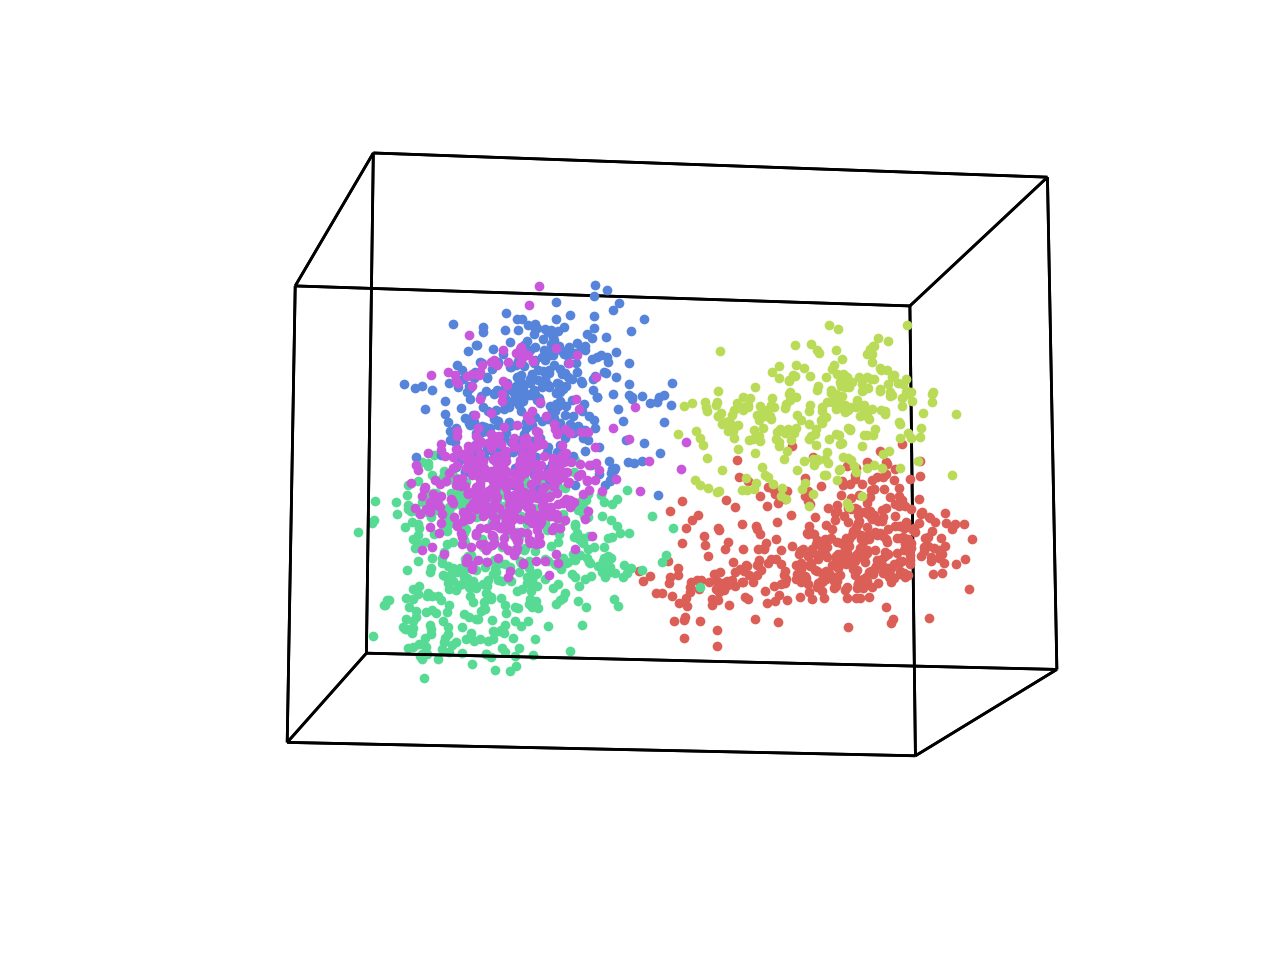

In [29]:
a = hyp.plot(np.array(abs_sasa_list),'.',animate=False,n_clusters=5,ndims=3)

<IPython.core.display.Javascript object>


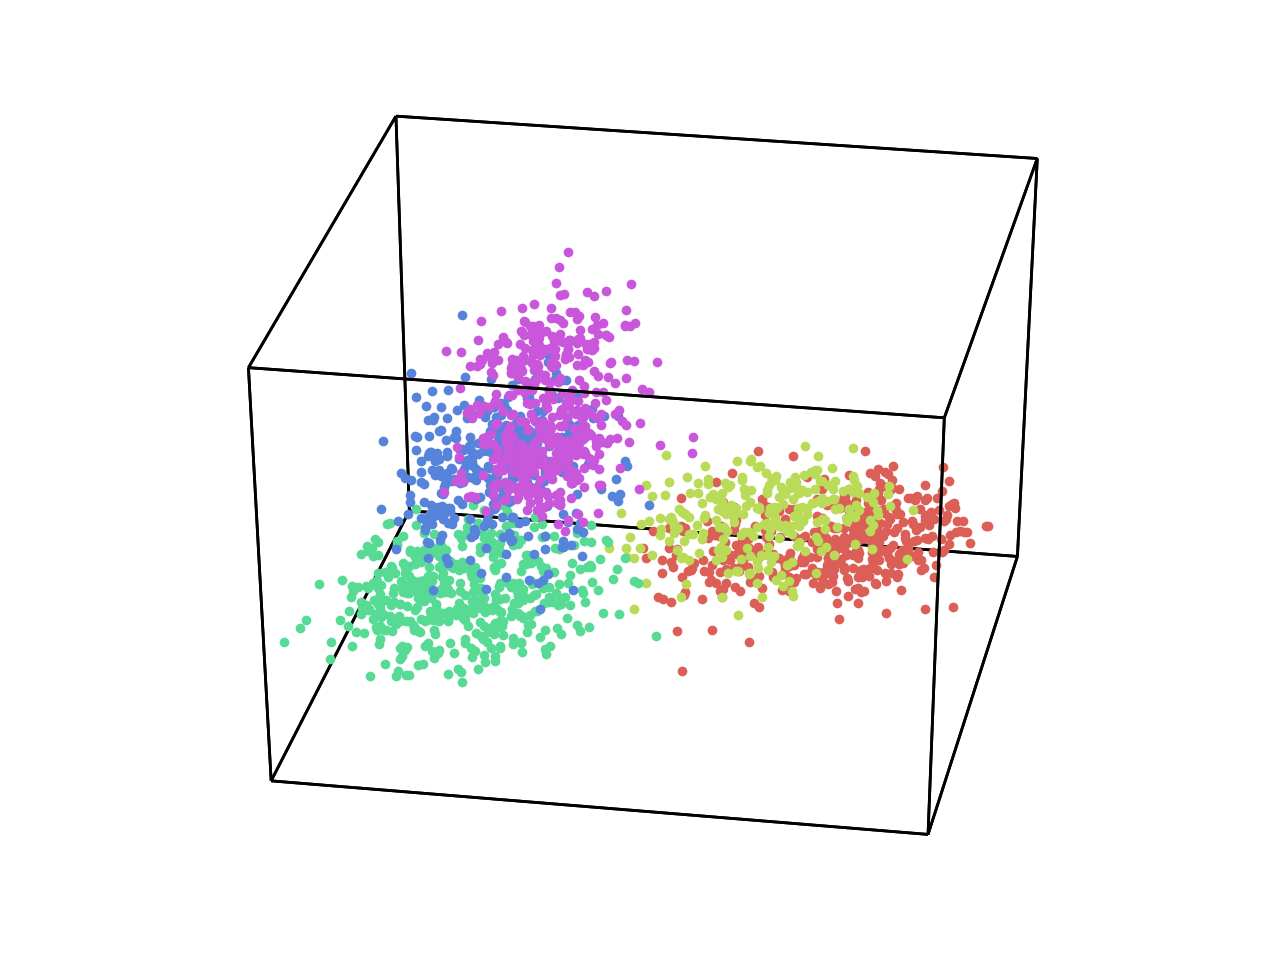

In [8]:
a = hyp.plot(np.array(abs_sasa_list),'.',n_clusters=5)

<IPython.core.display.Javascript object>


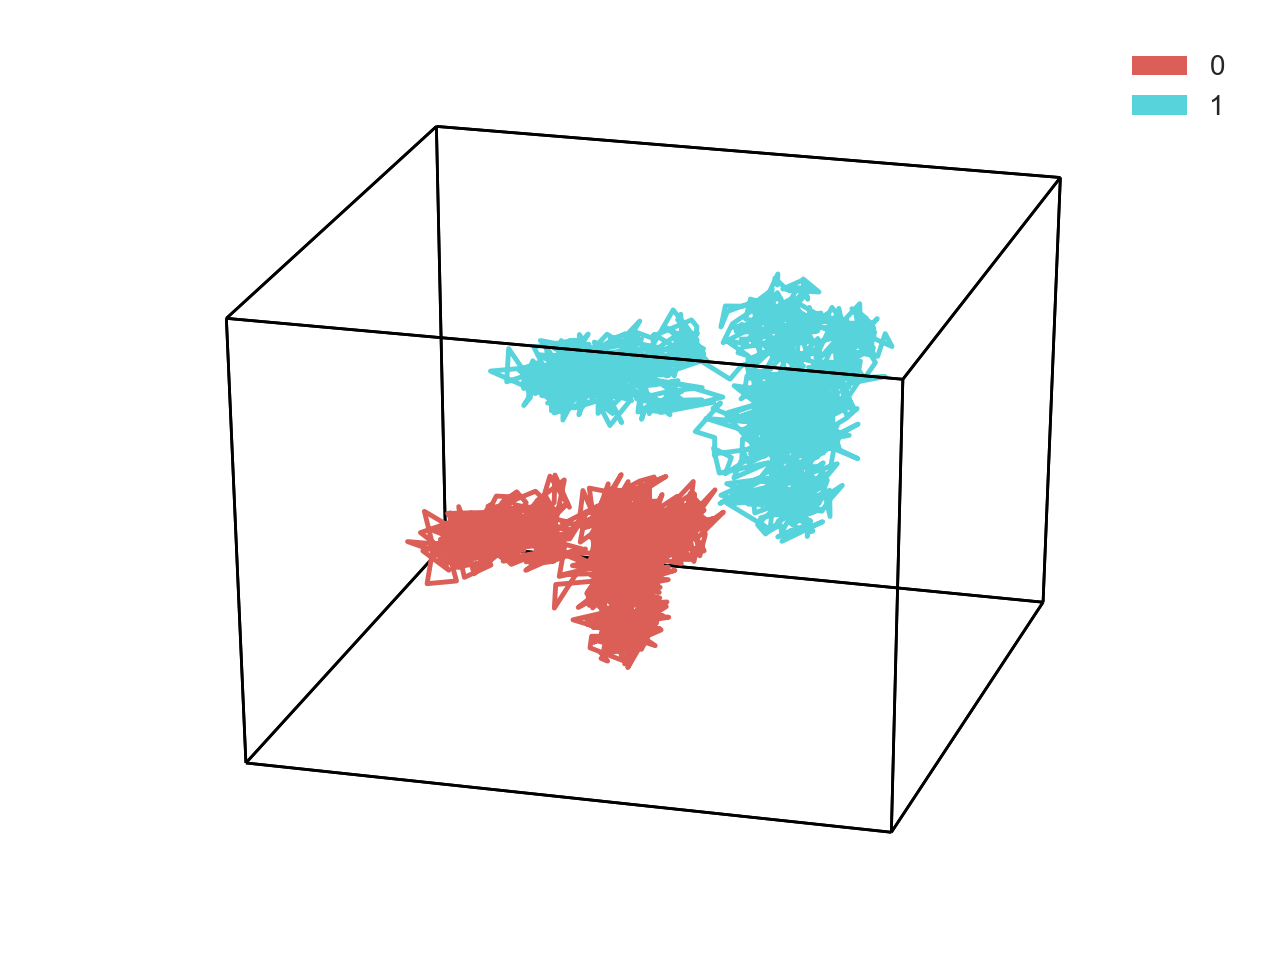

In [15]:
grouping = ['delta_sasa'] * len(abs_sasa_list) + ['sasa'] * len(abs_sasa_list)
a = hyp.plot([np.array(abs_sasa_list),np.array(sasa_list)],legend=True,group=grouping)

In [4]:
a = hyp.plot(np.array(abs_sasa_list),animate=True,tail_duration=99,
             save_path='/Users/haotian/Desktop/PCA_delta_anamation.mp4'
            )

Using matplotlib backend: MacOSX


/Users/haotian/anaconda3/lib/python3.6/site-packages/hypertools/tools/describe.py:56: UserWarning: When input data is large, this computation can take a long time.
  warnings.warn('When input data is large, this computation can take a long time.')


<IPython.core.display.Javascript object>


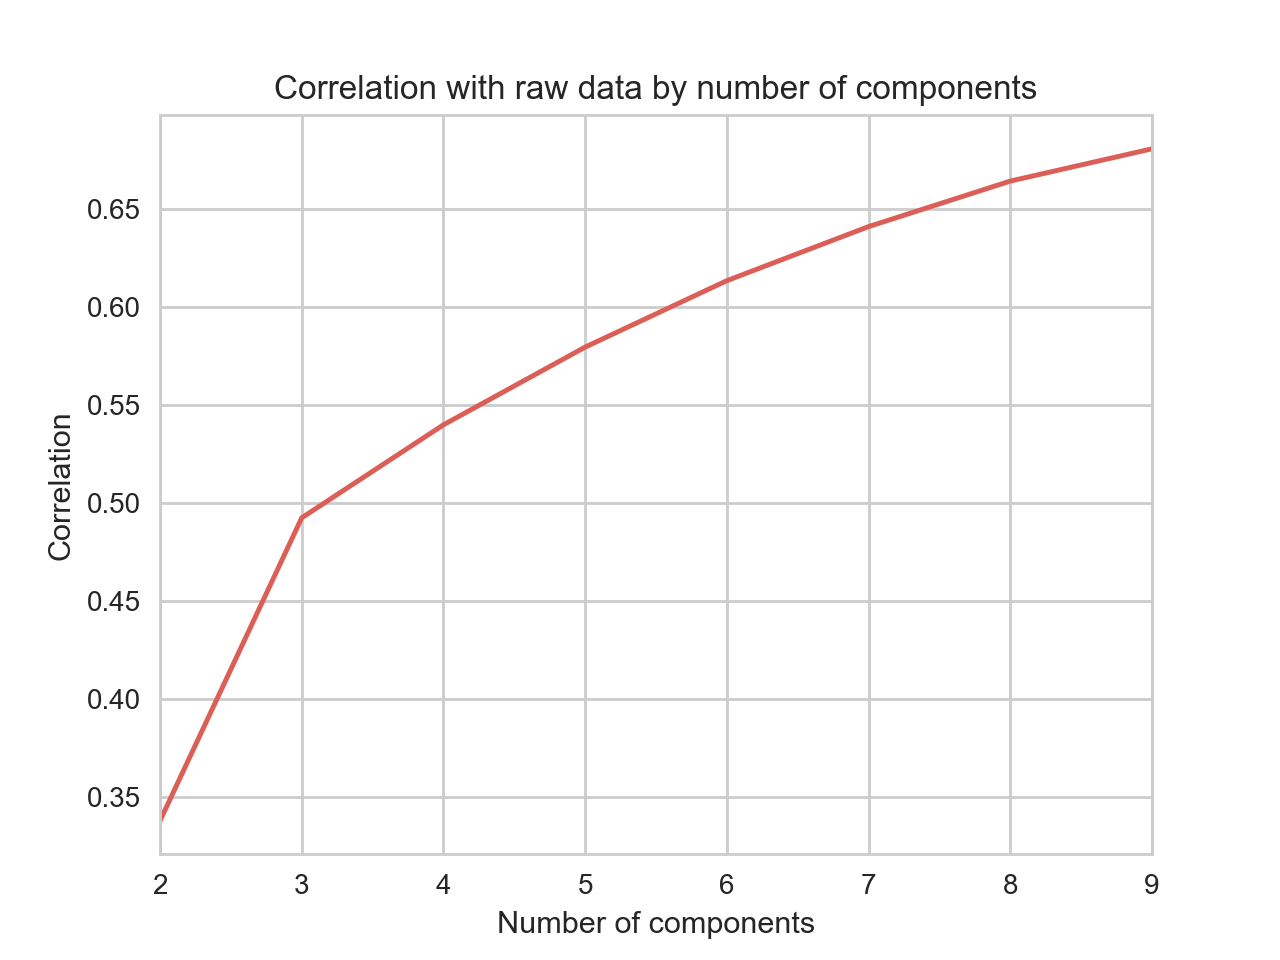

/Users/haotian/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


{'average': [0.3376698920511578,
  0.4924541301049125,
  0.5399667266346814,
  0.5796770674675913,
  0.6136260759948052,
  0.6412459675131867,
  0.6644934859525387,
  0.6809952058617633],
 'individual': [[0.3376698920511578,
   0.4924541301049125,
   0.5399667266346814,
   0.5796770674675913,
   0.6136260759948052,
   0.6412459675131867,
   0.6644934859525387,
   0.6809952058617633]]}

In [32]:
hyp.describe(np.array(sasa_list),max_dims=10)